# MovIA: Proyecto desarrollo de un Sistema de Recomendación de Películas con IA

## Fase 1: Preparación del Entorno y Datos

In [1]:
# Importación de bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import spacy
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gradio as gr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

from openai import OpenAI
from dotenv import load_dotenv
import os

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

In [2]:
# Para mostrar todas las filas y/o columnas del DataFrame
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [3]:
# Lectura de los DataSets
df_credits = pd.read_csv('tmdb_5000_credits.csv')
df_movies = pd.read_csv('tmdb_5000_movies.csv')
print(df_credits.columns)
print(df_movies.columns)

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')
Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')


In [4]:
# Se cambia la columna 'movie_id' del DataFrame df_credits a 'id' para poder hacer un merge posteriormente
df_credits.columns = ['id', 'title', 'cast', 'crew']

# Se elimina la columna 'title' ya que está en ambos DataFrames y aparecería duplicada una vez se haga el merge
df_credits.drop(['title'], axis=1, inplace=True)
df_credits.head()

,id,cast,crew
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
# Se hace el merge
df_merge = df_movies.merge(df_credits, on='id')
df_merge.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Fase 2: Análisis Exploratorio de Datos (EDA) y Procesamiento del Lenguaje Natural (NLP)

### EDA

In [6]:
# Tamaño del DataFrame
df_merge.shape

(4803, 22)

In [7]:
df_merge.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


df_merge.info()

#### Revisión de nulos

In [8]:
# Cantidad de nulos

null_counts = df_merge.isnull().sum()
print("Número de valores nulos por columna:")
print(null_counts[null_counts > 0])

Número de valores nulos por columna:
homepage        3091
overview           3
release_date       1
runtime            2
tagline          844
dtype: int64


- *homepage*: Se eiminará dicha columna ya que tiene un alto contenido de nulos y no tiene información relevante para el objetivo del proyecto
- *overview*: Se eliminarás las filas con esos valores nulos ya que son muy pocos
- *release_date*: Se eliminarán la fila con ese valor nulo
- *runtime*: Se reemplazarán las filas con esos valores nulos por la mediana
- *tagline*: Se reemplazarán los valores nulos por el texto 'Not available'

In [9]:
# Se elimina la columna 'homepage'
df_merge.drop(['homepage'], axis=1, inplace=True)

# Se eliminan las filas con valores nulos en 'overview' y 'release_date'
df_merge.dropna(subset=['overview', 'release_date'], inplace=True)

# Se reemplazan los valores nulos en 'runtime' con la mediana
median_runtime = df_merge['runtime'].median()
df_merge['runtime'].fillna(median_runtime, inplace=True)

# Se reemplazan los valores nulos en 'tagline' con 'Not available'
df_merge['tagline'].fillna('Not available', inplace=True)

/var/folders/79/rwrch1qx1y7bm5mc3hnnntw00000gn/T/ipykernel_66173/3967676929.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merge['runtime'].fillna(median_runtime, inplace=True)
/var/folders/79/rwrch1qx1y7bm5mc3hnnntw00000gn/T/ipykernel_66173/3967676929.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [10]:
# Verificación del tratamiento de nulos
null_counts = df_merge.isnull().sum()
print("Número de valores nulos por columna:")
print(null_counts[null_counts > 0])

Número de valores nulos por columna:
Series([], dtype: int64)


#### Valores atípicos

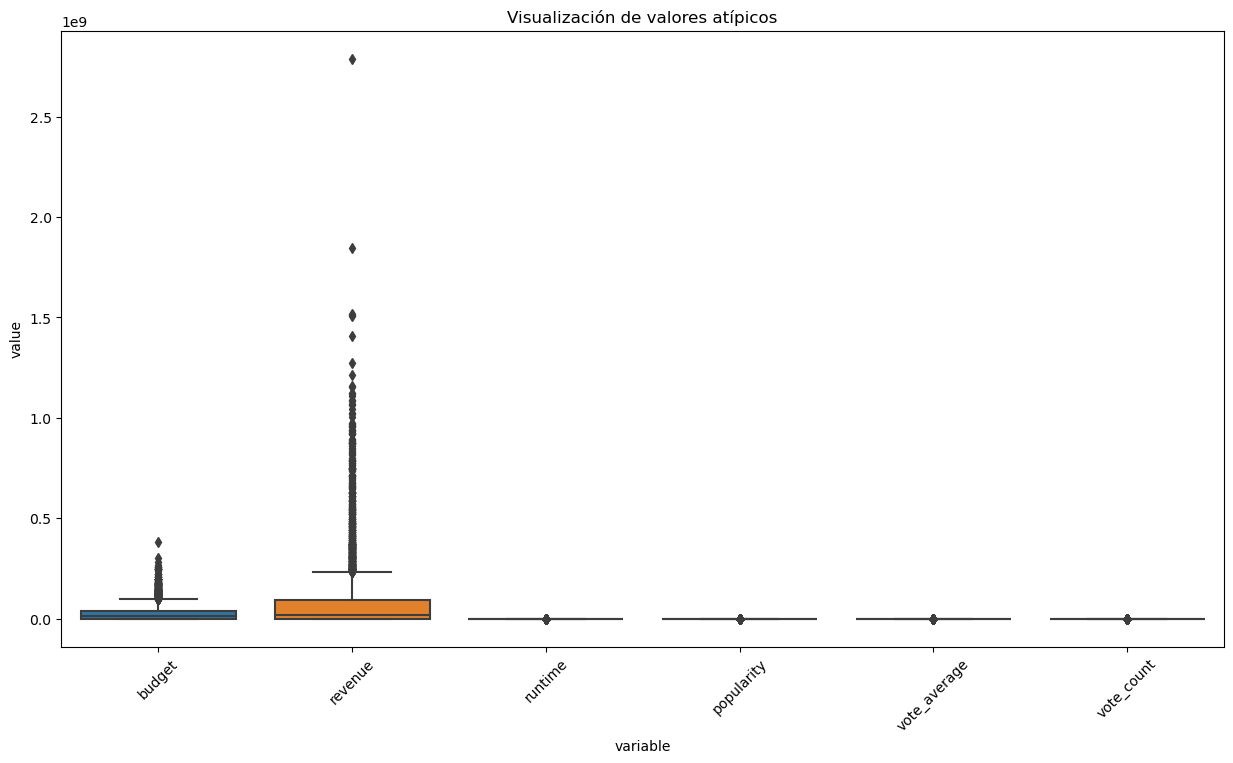

In [11]:
# Visualizar valores atípicos
plt.figure(figsize=(15, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(df_merge[['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']]))
plt.title("Visualización de valores atípicos")
plt.xticks(rotation=45)
plt.show()

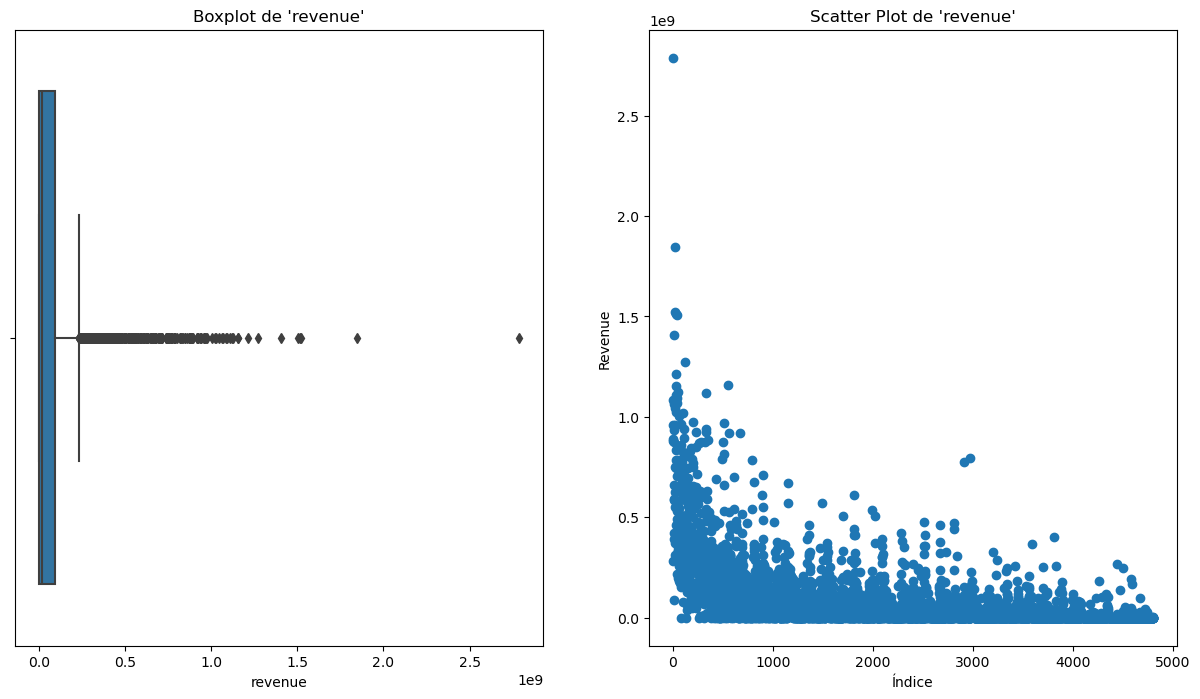

In [12]:
# Visualización con Boxplot y Scatter Plot para 'revenue'
plt.figure(figsize=(15, 8))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_merge['revenue'])
plt.title("Boxplot de 'revenue'")

# Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(x=df_merge.index, y=df_merge['revenue'])
plt.title("Scatter Plot de 'revenue'")
plt.xlabel("Índice")
plt.ylabel("Revenue")
plt.show()

Parece que en la variable 'revenue' hay un valor muy alto. Se va a analizar dicho registro:

In [13]:
revenue_max = df_merge['revenue'].max()

df_merge[df_merge['revenue'] == revenue_max]

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


Dicho valor corresponde a la película Avatar, siendo esta una de las películas más taquillera de la historia, por lo que dicho valor tan alto es válido y no se va a eliminar

#### Filtro para tener las películas con un número elevado de votos

In [14]:
# Mediana de los votos y conteo
print(f"La mediana de la nota de las películas es de: {df_merge['vote_average'].median()}")
print(f"La mediana de la cantidad de votos de las películas es de: {df_merge['vote_count'].median()}")

La mediana de la nota de las películas es de: 6.2
La mediana de la cantidad de votos de las películas es de: 236.0


Se van a mantener sólo las películas que tienen un mayor número de votos ya que tendrá calificaciones más fiables. Se usa el percentil 70

In [15]:
percentil_70 = df_merge['vote_count'].quantile(0.70)
print(percentil_70)

581.0


In [16]:
# Cantidad de películas dentro del percentil 70 más votado
print(f"La cantidad de películas que están dentro del percentil 70 son {len(df_merge[df_merge['vote_count']>percentil_70])}")

La cantidad de películas que están dentro del percentil 70 son 1438


In [17]:
# Se hace una copia del DataFrame con el filtro del percentil para no alterar el original
df_merge_percentil = df_merge.copy().loc[df_merge['vote_count'] > percentil_70]

#### 'original_title' vs 'title'

In [18]:
# Bucle para comparar 'original_title' y 'title'
for index, row in df_merge_percentil.iterrows():
    original_title = row['original_title']
    title = row['title']
    
    # Verificar si 'original_title' y 'title' son iguales
    if original_title != title:
        print(f"Índice {index}: 'original_title' ({original_title}) es diferente de 'title' ({title})")

Índice 215: 'original_title' (4: Rise of the Silver Surfer) es diferente de 'title' (Fantastic 4: Rise of the Silver Surfer)
Índice 488: 'original_title' (Arthur et les Minimoys) es diferente de 'title' (Arthur and the Invisibles)
Índice 1136: 'original_title' (英雄) es diferente de 'title' (Hero)
Índice 1255: 'original_title' (Lo imposible) es diferente de 'title' (The Impossible)
Índice 1260: 'original_title' (Le fabuleux destin d'Amélie Poulain) es diferente de 'title' (Amélie)
Índice 1471: 'original_title' (崖の上のポニョ) es diferente de 'title' (Ponyo)
Índice 1761: 'original_title' (The Neverending Story) es diferente de 'title' (The NeverEnding Story)
Índice 1945: 'original_title' (La migliore offerta) es diferente de 'title' (The Best Offer)
Índice 1987: 'original_title' (ハウルの動く城) es diferente de 'title' (Howl's Moving Castle)
Índice 2184: 'original_title' (功夫) es diferente de 'title' (Kung Fu Hustle)
Índice 2247: 'original_title' (もののけ姫) es diferente de 'title' (Princess Mononoke)
Índi

In [19]:
# Lista de índices que quieres visualizar
indices_a_visualizar = [1136, 1471, 1987, 2515]

# Utilizar el método loc para seleccionar los registros en esos índices
df_merge_percentil[['original_title', 'title']].loc[indices_a_visualizar]

,original_title,title
1136,英雄,Hero
1471,崖の上のポニョ,Ponyo
1987,ハウルの動く城,Howl's Moving Castle
2515,卧虎藏龙,"Crouching Tiger, Hidden Dragon"


Dado que la columna 'original_title' contiene caracteres especiales o está en otro idioma al inglés en algunos de los registros, se opta por eliminar dicha columna y mantener la columna 'title'

In [20]:
# Eliminar la columna 'original_title'
df_merge_percentil.drop(['original_title'], axis=1, inplace=True)

#### Exploración más detallada de las columnas

In [21]:
# Lista de columnas a revisar. Estas son columnas que tienen como información una lista de diccionarios
columns_to_explore = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew']

# Bucle para explorar cada columna
for column in columns_to_explore:
    print(f"Explorando la columna: {column}\n")
    
    # Imprimir algunos valores de la columna
    sample_values = df_merge_percentil[column].sample(5, random_state=42).tolist()
    
    # Imprimir información
    print(f"Algunos valores de la columna:\n{sample_values}\n")
    print(f"Número total de valores únicos: {df_merge[column].nunique()}\n")
    print("#" * 50 + "\n")

Explorando la columna: genres

Algunos valores de la columna:
['[{"id": 28, "name": "Action"}, {"id": 878, "name": "Science Fiction"}, {"id": 12, "name": "Adventure"}]', '[{"id": 18, "name": "Drama"}, {"id": 10749, "name": "Romance"}]', '[{"id": 18, "name": "Drama"}, {"id": 10402, "name": "Music"}]', '[{"id": 35, "name": "Comedy"}, {"id": 10749, "name": "Romance"}]', '[{"id": 16, "name": "Animation"}, {"id": 10751, "name": "Family"}]']

Número total de valores únicos: 1175

##################################################

Explorando la columna: keywords

Algunos valores de la columna:
['[{"id": 4565, "name": "dystopia"}, {"id": 10891, "name": "giant robot"}, {"id": 11100, "name": "giant monster"}, {"id": 12332, "name": "apocalypse"}, {"id": 156395, "name": "imax"}, {"id": 179431, "name": "duringcreditsstinger"}, {"id": 209714, "name": "3d"}]', '[{"id": 933, "name": "michigan"}, {"id": 1228, "name": "1970s"}, {"id": 14751, "name": "youth"}, {"id": 18035, "name": "family"}, {"id": 187

Se van a eliminar estas columnas excepto 'genres', 'keywords' y 'cast', ya que tienen información relevante para el objetivo del proyecto

In [22]:
# Lista de columnas a eliminar
columns_to_explore = ['production_companies', 'production_countries', 'spoken_languages', 'crew']

# ELiminación de dichas columnas
df_merge_percentil.drop(columns=columns_to_explore, inplace=True)

In [23]:
# Comprobación de que se han eliminado correctamente
df_merge_percentil.head()

,budget,genres,id,keywords,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,cast
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,2012-07-16,1084939099,165.0,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,2012-03-07,284139100,132.0,Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [24]:
# Valores diferentes de la columna status
df_merge_percentil['status'].value_counts()

status
Released    1438
Name: count, dtype: int64

In [25]:
# Se elimina dicha variable
df_merge_percentil.drop(columns=['status'], inplace=True)

In [26]:
df_merge_percentil[['genres','keywords','cast']].head()

,genres,keywords,cast
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


Se va a extraer la información de las columnas 'genres', 'keywords' y 'cast'

In [27]:
# Función para extraer los valores de la clave "name" y unirlos por espacio
def extract_names(value):
    try:
        #convierte la cadena JSON en una lista de diccionarios
        items = ast.literal_eval(value)
        #extrae los valores de la clave "name"
        names = [item.get("name", "") for item in items]
        #une los valores por espacio
        return " ".join(names)
    except (ValueError, SyntaxError) as e:
        return str(e)

In [28]:
# Uso de la función extract_names en las columnas correspondientes
df_merge_percentil['genres'] = df_merge_percentil['genres'].apply(extract_names)
df_merge_percentil['keywords'] = df_merge_percentil['keywords'].apply(extract_names)
df_merge_percentil['cast'] = df_merge_percentil['cast'].apply(extract_names)

In [29]:
# Información después de la transformación
print("DataFrame después de la transformación:")
df_merge_percentil[['genres', 'keywords', 'cast']].head()

DataFrame después de la transformación:


,genres,keywords,cast
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...
2,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,Daniel Craig Christoph Waltz Léa Seydoux Ralph...
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...


In [30]:
# Combinación de las columnas overview, genres, keywords y cast en una sola
df_merge_percentil['combined_text'] = df_merge_percentil['overview'] + ' ' + df_merge_percentil['cast'] + ' ' + df_merge_percentil['genres'] + ' ' + df_merge_percentil['keywords']
df_merge_percentil['combined_text'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: combined_text, dtype: object

In [31]:
'''
#Se ejecuta lo siguiente para tener el .csv con la columna combined_text y pasarle un Embedding y subirlo a AstraDB

# Combinación de las columnas overview + title y se crea un dataframe con esa combinación
df_title_overview = pd.DataFrame({
    'combined_text': df_merge_percentil['title'] + ' ' + df_merge_percentil['overview']
})



df_title_overview.to_csv('df_title_overview.csv')
'''

"\n#Se ejecuta lo siguiente para tener el .csv con la columna combined_text y pasarle un Embedding y subirlo a AstraDB\n\n# Combinación de las columnas overview + title y se crea un dataframe con esa combinación\ndf_title_overview = pd.DataFrame({\n    'combined_text': df_merge_percentil['title'] + ' ' + df_merge_percentil['overview']\n})\n\n\n\ndf_title_overview.to_csv('df_title_overview.csv')\n"

### NLP

Se va a realizar una Tokenización y Eliminación de StopWords

In [32]:
#Descarga del modelo de spaCy en inglés
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [33]:
# Descarga de las stopwords y punkt
nltk.download('stopwords')
nltk.download('punkt')
# Carga el modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/n.c.rodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/n.c.rodriguez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# Función de tokenización y eliminación de stopwords con NLTLK + Stemming
def preprocessing(text):
    # Tokenización
    tokens = word_tokenize(text)
    
    # Eliminación de stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [35]:
# Uso de la función preprocessing en la columna combined_text
df_merge_percentil['combined_text_preprocessed'] = df_merge_percentil['combined_text'].apply(preprocessing)

In [36]:
df_merge_percentil['combined_text_preprocessed'].head()

0    [centuri, parapleg, marin, dispatch, moon, pan...
1    [captain, barbossa, long, believ, dead, come, ...
2    [cryptic, messag, bond, past, send, trail, unc...
3    [follow, death, district, attorney, harvey, de...
4    [john, carter, former, militari, captain, inex...
Name: combined_text_preprocessed, dtype: object

In [37]:
df_merge_percentil.head()

,budget,genres,id,keywords,original_language,overview,popularity,release_date,revenue,runtime,tagline,title,vote_average,vote_count,cast,combined_text,combined_text_preprocessed
0,237000000,Action Adventure Fantasy Science Fiction,19995,culture clash future space war space colony so...,en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"In the 22nd century, a paraplegic Marine is di...","[centuri, parapleg, marin, dispatch, moon, pan..."
1,300000000,Adventure Fantasy Action,285,ocean drug abuse exotic island east india trad...,en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"Captain Barbossa, long believed to be dead, ha...","[captain, barbossa, long, believ, dead, come, ..."
2,245000000,Action Adventure Crime,206647,spy based on novel secret agent sequel mi6 bri...,en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz Léa Seydoux Ralph...,A cryptic message from Bond’s past sends him o...,"[cryptic, messag, bond, past, send, trail, unc..."
3,250000000,Action Crime Drama Thriller,49026,dc comics crime fighter terrorist secret ident...,en,Following the death of District Attorney Harve...,112.312950,2012-07-16,1084939099,165.0,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,Following the death of District Attorney Harve...,"[follow, death, district, attorney, harvey, de..."
4,260000000,Action Adventure Science Fiction,49529,based on novel mars medallion space travel pri...,en,"John Carter is a war-weary, former military ca...",43.926995,2012-03-07,284139100,132.0,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"John Carter is a war-weary, former military ca...","[john, carter, former, militari, captain, inex..."


In [38]:
df_merge_percentil.shape

(1438, 17)

## Fase 3: Generación y Análisis de Sentimientos

Se generan reviews con OpenAI y un análisis de sentimiento con BERT

### Generación de reviews con OpenAI

In [39]:
'''
# Se guarda en una lista los títulos de las películas

lista_titulos = df_merge_percentil['title'].to_list()

lista_titulos
'''

"\n# Se guarda en una lista los títulos de las películas\n\nlista_titulos = df_merge_percentil['title'].to_list()\n\nlista_titulos\n"

In [40]:
'''
# Cargar variables de entorno
load_dotenv()

# Configurar el motor de OpenAI
engine = "gpt-3.5-turbo"
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
'''

'\n# Cargar variables de entorno\nload_dotenv()\n\n# Configurar el motor de OpenAI\nengine = "gpt-3.5-turbo"\nclient = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))\n'

In [41]:
'''
# Definición de la función completition para usar openAI y obtener una review de la película
def get_completion(prompt):
    completion = client.chat.completions.create(
        model=engine,
            messages=[
                {"role": "system", "content": "You are an expert at reviewing a movie knowing its title. \
                Such review should be no longer than 5 lines"},
                {"role": "user", "content": f"{prompt}"}
            ]
        )
    return completion
'''

'\n# Definición de la función completition para usar openAI y obtener una review de la película\ndef get_completion(prompt):\n    completion = client.chat.completions.create(\n        model=engine,\n            messages=[\n                {"role": "system", "content": "You are an expert at reviewing a movie knowing its title.                 Such review should be no longer than 5 lines"},\n                {"role": "user", "content": f"{prompt}"}\n            ]\n        )\n    return completion\n'

In [42]:
'''
# Ejemplo de uso para la película 
prompt = ("Spider-Man 3")
respuesta = get_completion(prompt) 
print(respuesta.choices[0].message.content)
'''

'\n# Ejemplo de uso para la película \nprompt = ("Spider-Man 3")\nrespuesta = get_completion(prompt) \nprint(respuesta.choices[0].message.content)\n'

In [43]:
'''
# Creación de reviews de cada película 
# Primero se inicializan dos listas para almacenar títulos y reseñas
titles = []
reviews = []

# Se recorren todos los títulos almacenados en la lista creada en la celda anterior
for titulo in lista_titulos:
    #generar revisión para el título actual
    respuesta = get_completion(titulo)
    #almacenar título y revisión en las listas respectivas
    titles.append(titulo)
    reviews.append(respuesta.choices[0].message.content)
'''

'\n# Creación de reviews de cada película \n# Primero se inicializan dos listas para almacenar títulos y reseñas\ntitles = []\nreviews = []\n\n# Se recorren todos los títulos almacenados en la lista creada en la celda anterior\nfor titulo in lista_titulos:\n    #generar revisión para el título actual\n    respuesta = get_completion(titulo)\n    #almacenar título y revisión en las listas respectivas\n    titles.append(titulo)\n    reviews.append(respuesta.choices[0].message.content)\n'

In [44]:
'''
# Creación de reviews de cada película y mostrando el progreso de ejecución
from tqdm.notebook import tqdm

# Inicialización de listas para almacenar títulos y reseñas
titles = []
reviews = []

# Crear una barra de progreso
for titulo in tqdm(lista_titulos, desc="Procesando películas", unit="película"):
    # Generar revisión para el título actual
    respuesta = get_completion(titulo)
    # Almacenar título y revisión en las listas respectivas
    titles.append(titulo)
    reviews.append(respuesta.choices[0].message.content)
'''

'\n# Creación de reviews de cada película y mostrando el progreso de ejecución\nfrom tqdm.notebook import tqdm\n\n# Inicialización de listas para almacenar títulos y reseñas\ntitles = []\nreviews = []\n\n# Crear una barra de progreso\nfor titulo in tqdm(lista_titulos, desc="Procesando películas", unit="película"):\n    # Generar revisión para el título actual\n    respuesta = get_completion(titulo)\n    # Almacenar título y revisión en las listas respectivas\n    titles.append(titulo)\n    reviews.append(respuesta.choices[0].message.content)\n'

In [45]:
'''
# Se crea un DataFrame con los resultados
df_reviews = pd.DataFrame({'title': titles, 'review': reviews})
'''

"\n# Se crea un DataFrame con los resultados\ndf_reviews = pd.DataFrame({'title': titles, 'review': reviews})\n"

In [46]:
'''
df_reviews
'''

'\ndf_reviews\n'

In [47]:
'''
# Se va a guardar el DataFrame con las reviews generadas por gpt en un archivo .csv
df_reviews.to_csv('df_reviews.csv')
'''

"\n# Se va a guardar el DataFrame con las reviews generadas por gpt en un archivo .csv\ndf_reviews.to_csv('df_reviews.csv')\n"

Los códigos de las celdas anteriores que están entre triples comillas simples son los usados para generar la review de cada película con la API de OpenAI. Se comentan ya que su ejecución es algo lenta porque tiene que generarse una review para cada una de las 1.438 películas.

Esta información se ha guardado en un csv llamado 'df_reviews.csv' y que se leey usa a continuación

In [48]:
# Se crea el df_reviews a partir del .csv creado anteriormente
df_reviews = pd.read_csv('df_reviews.csv', index_col = None)
df_reviews = df_reviews.drop(columns=['Unnamed: 0'])
df_reviews


,title,review
0,Avatar,"""Avatar"" is a visually stunning masterpiece th..."
1,Pirates of the Caribbean: At World's End,"""Pirates of the Caribbean: At World's End"" is ..."
2,Spectre,"""Spectre"" is an action-packed thrill ride that..."
3,The Dark Knight Rises,"""The Dark Knight Rises"" is a thrilling conclus..."
4,John Carter,"""John Carter"" is an ambitious sci-fi adventure..."
...,...,...
1433,The Man from Earth,"""The Man from Earth"" is a thought-provoking an..."
1434,Pi,"""Pi"" is a mind-bending, mathematical thriller ..."
1435,The Signal,"""The Signal"" is a mind-bending sci-fi thriller..."
1436,Clerks,"""Clerks"" is a cult classic that perfectly capt..."


In [49]:
# Se hace el merge de df_reviews con df_merge_percentil
df_merge_percentil_reviews = df_merge_percentil.merge(df_reviews, on='title')
df_merge_percentil_reviews.head()

,budget,genres,id,keywords,original_language,overview,popularity,release_date,revenue,runtime,tagline,title,vote_average,vote_count,cast,combined_text,combined_text_preprocessed,review
0,237000000,Action Adventure Fantasy Science Fiction,19995,culture clash future space war space colony so...,en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"In the 22nd century, a paraplegic Marine is di...","[centuri, parapleg, marin, dispatch, moon, pan...","""Avatar"" is a visually stunning masterpiece th..."
1,300000000,Adventure Fantasy Action,285,ocean drug abuse exotic island east india trad...,en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"Captain Barbossa, long believed to be dead, ha...","[captain, barbossa, long, believ, dead, come, ...","""Pirates of the Caribbean: At World's End"" is ..."
2,245000000,Action Adventure Crime,206647,spy based on novel secret agent sequel mi6 bri...,en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz Léa Seydoux Ralph...,A cryptic message from Bond’s past sends him o...,"[cryptic, messag, bond, past, send, trail, unc...","""Spectre"" is an action-packed thrill ride that..."
3,250000000,Action Crime Drama Thriller,49026,dc comics crime fighter terrorist secret ident...,en,Following the death of District Attorney Harve...,112.312950,2012-07-16,1084939099,165.0,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,Following the death of District Attorney Harve...,"[follow, death, district, attorney, harvey, de...","""The Dark Knight Rises"" is a thrilling conclus..."
4,260000000,Action Adventure Science Fiction,49529,based on novel mars medallion space travel pri...,en,"John Carter is a war-weary, former military ca...",43.926995,2012-03-07,284139100,132.0,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"John Carter is a war-weary, former military ca...","[john, carter, former, militari, captain, inex...","""John Carter"" is an ambitious sci-fi adventure..."


### Implementación de una GAN para generar nuevas reviews (valorar si hacerlo)

### Análisis de sentimientos con BERT

In [50]:
# Se carga el modelo de análisis de sentimientos
model_sentiment_analysis = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [51]:
# Se preprocesa y se analiza la review usando el modelo de análisis de sentimientos
def analyze_sentiment_pipeline(review):
    result = model_sentiment_analysis(review)[0]
    sentiment_label = 1 if result['label'] == 'POSITIVE' else 0 if result['label'] == 'NEGATIVE' else -1
    confidence = result['score']
    return sentiment_label, confidence

In [52]:
# Ejemplo de reseña
sample_review = "The movie was fantastic! I loved every moment of it."

# Analizar sentimiento con el modelo de análisis de sentimientos
sentiment_label_pipeline, confidence_pipeline = analyze_sentiment_pipeline(sample_review)

In [53]:
# Mostrar resultados para el modelo de análisis de sentimientos
print("Pipeline Sentimiento:", "Positivo" if sentiment_label_pipeline == 1 else "Negativo" if sentiment_label_pipeline == 0 else "Neutral")
print("Pipeline Confianza:", confidence_pipeline)

Pipeline Sentimiento: Positivo
Pipeline Confianza: 0.9998797178268433


In [54]:
# Se crea una nueva columna para el resultado del análisis de sentimiento:
df_merge_percentil_reviews['sentiment'] = "" #se incializa con una cadena vacía

# Se aplica la función analyze_sentiment_pipeline usando un bucle para recorrer todas las reviews:
for index, row in df_merge_percentil_reviews.iterrows():
    review = row['review']
    sentiment_label, _ = analyze_sentiment_pipeline(review)

    #se almacena el resultado en la nueva columna
    df_merge_percentil_reviews.at[index, 'sentiment'] = "Positivo" if sentiment_label == 1 else "Negativo" if sentiment_label == 0 else "Neutro"

In [55]:
# Se muestra la cantidad de cada tipo de sentimiento generado con BERT
df_merge_percentil_reviews['sentiment'].value_counts()

sentiment
Positivo    1358
Negativo      80
Name: count, dtype: int64

## Fase 4: Sistema de Recomendación

In [56]:
# Función para guardar en un pickle la tfidf_matrix
def save_recomendation(tfidf_matrix):
    with open('tfidf_matrix.pickle', 'wb') as handle:
        pickle.dump(tfidf_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
# Se define la función de entrenamiento
def train_recommendation():

    #se crea el TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    #Fit y transform de la columna combinada
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_merge_percentil_reviews['combined_text'])

    #se guarda la matriz con la función save_recomendation creada
    save_recomendation(tfidf_matrix)
    return tfidf_matrix

In [58]:
# Función para cargar el pickle de la tfidf_matrix
def load_tfidf_matrix():
    with open('tfidf_matrix.pickle', 'rb') as handle:
        tfidf_matrix = pickle.load(handle)
    return tfidf_matrix

In [96]:
# Función de recomendación que devuelve las N películas recomendadas y si se desea la review de cada una de ellas
def recommendation_with_review(reference_movie_index, show_reviews_and_sentiment):
    # Si existe el fichero con la matriz lo cargamos, si no llamamos a train_recommendation
    try:
        tfidf_matrix = load_tfidf_matrix()
    except:
        tfidf_matrix = train_recommendation()

    #se calcula el cosine_similarity con todas las películas
    cosine_sim_scores = cosine_similarity(tfidf_matrix[reference_movie_index], tfidf_matrix)

    #se coge el índice con mayor similitud (exlcuyendo la película de referencia)
    similar_movie_indices = cosine_sim_scores.argsort()[0][::-1][1:]

    #se coge el top N de películas más parecidas a la de referencia y se muestran
    top_N = 10  #se puede ajustar a la cantidad de películas a referenciar deseadas
    recommended_movies = df_merge_percentil_reviews.iloc[similar_movie_indices[:top_N]]

    #si se elige mostrar las reviews y el sentimiento
    if show_reviews_and_sentiment:
        # Se obtienen las reviews de las películas recomendadas
        formatted_output = ""
        for _, movie in recommended_movies.iterrows():
            formatted_output += f'Título: {movie["title"]}\nReview: {movie["review"]}\Sentimiento: {movie["sentiment"]}\n\n'

        return formatted_output
    else:
        return "\n".join(recommended_movies['title'].tolist())

In [97]:
# Se crea una lista de diccionarios para el dropdown de la interfaz de Gradio
movie_options = [(row["title"], index) for index, row in df_merge_percentil_reviews.iterrows()]

In [99]:
# Se crea la interfaz web con Gradio
demo = gr.Interface(
    recommendation_with_review,
    [
        gr.Dropdown(
            movie_options, label="Película", info="Selecciona una película que te haya gustado"
        ),
        gr.Checkbox("¿Quieres leer la review de las películas recomendadas?"),
    ],
    "text"
)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7873


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Could not create share link. Missing file: /Users/n.c.rodriguez/anaconda3/envs/nico/lib/python3.10/site-packages/gradio/frpc_darwin_arm64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_darwin_arm64
2. Rename the downloaded file to: frpc_darwin_arm64_v0.2
3. Move the file to this location: /Users/n.c.rodriguez/anaconda3/envs/nico/lib/python3.10/site-packages/gradio
